# Part 3: 從 Xarray 到 ML Pipeline

這個 notebook 是整個 workshop 的核心，展示如何將大型 N-D array 資料無縫整合到機器學習流程中。

## 本節內容

1. **定義 ML 任務**：對流分類（Convection Classification）
2. **建立 Labels**：從 CAPE 定義對流事件
3. **xbatcher**：產生訓練用的時空 patches
4. **PyTorch 整合**：使用 `xbatcher.loaders.torch.MapDataset`
5. **模型訓練**：簡單的 CNN 分類器
6. **空間驗證**：使用 xskillscore 評估預測品質

---

## 學習目標

- 理解「時空 batch」的概念
- 掌握 xbatcher 的兩階段設計（BatchGenerator → MapDataset）
- 正確設定 DataLoader 參數（batch_size=None！）
- 從 Xarray 到 PyTorch Tensor 的資料流
- 保留空間資訊進行驗證（vs 丟棄空間資訊的傳統 ML）

## 0. 環境準備

In [1]:
import dask
from dask.distributed import Client
import xarray as xr
import xbatcher
from xbatcher.loaders.torch import MapDataset
import intake
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 啟動 Dask Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='2GB')
print(f"Dask Dashboard: {client.dashboard_link}")

# 載入 catalog
catalog = intake.open_catalog('catalog.yaml')

/home/sungche/NAS/workshop/python-parallel-data-processing/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33031 instead
  warnings.warn(


Dask Dashboard: http://127.0.0.1:33031/status


## 1. 定義 ML 任務：對流分類

### 什麼是對流分類？

對流（convection）是指空氣垂直運動導致的劇烈天氣現象：
- 雷暴（thunderstorms）
- 強降雨
- 冰雹、龍捲風

預報對流非常重要，但傳統數值模式的解析度不足。我們希望用 ML 從大尺度變數預測小尺度對流。

### 任務定義

**輸入（Features）**：
- CAPE（Convective Available Potential Energy）：對流可用位能
- CIN（Convective Inhibition）：對流抑制
- K-index：不穩定指數
- BLH（Boundary Layer Height）：邊界層高度

**輸出（Label）**：
- 二元分類：是否發生對流（0 or 1）

### Label 的定義

實務上，對流的定義可以是：
- 雷達回波 > 40 dBZ（需要雷達資料）
- 降雨強度 > 10 mm/hr（需要雨量資料）
- **簡化版**：CAPE > 某個閾值 + CIN < 某個閾值

這個 workshop 我們用簡化版，重點是展示流程，不是預報精度。

## 2. 準備資料與建立 Labels

### 2.1 載入資料

In [2]:
ds = catalog.era5_2019_chunked.to_dask()
ds

<xarray.Dataset> Size: 22GB
Dimensions:                                (time: 8760, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    boundary_layer_height                  (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    convective_available_potential_energy  (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    ...                                     ...
    specific_humidity                      (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    surface_pressure                       (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    temperature                            (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    u_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
    v_component_of_wind                    (time, level, latitude, longitude) float32 3GB dask.array<chunksize=(360, 4, 121, 161), meta=np.ndarray>
Attributes:
    last_updated:           2025-07-18 02:02:45.511267+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-12

In [3]:
print(ds)

<xarray.Dataset> Size: 22GB
Dimensions:                                (time: 8760, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 70kB 2019-01...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 683MB dask.array<chunksize=(360, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, lati

In [4]:
# Resample 到 daily 以減少資料量
ds_daily = ds.resample(time='1D').max()

print("Dataset:")
print(ds_daily)
print()
print(f"Shape: {ds_daily['convective_available_potential_energy'].shape}")
print(f"Total size: {ds_daily.nbytes / 1e9:.2f} GB")

Dataset:
<xarray.Dataset> Size: 910MB
Dimensions:                                (time: 365, latitude: 121,
                                            longitude: 161, level: 4)
Coordinates:
  * time                                   (time) datetime64[ns] 3kB 2019-01-...
  * latitude                               (latitude) float32 484B 40.0 ... 10.0
  * longitude                              (longitude) float32 644B 100.0 ......
  * level                                  (level) int64 32B 300 500 700 850
Data variables: (12/17)
    100m_u_component_of_wind               (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    100m_v_component_of_wind               (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    10m_u_component_of_wind                (time, latitude, longitude) float32 28MB dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    10m_v_component_of_wind                (time, lati

### 2.2 建立對流 Label

我們定義對流發生的條件：
- CAPE > 1000 J/kg（有足夠的不穩定能量）
- CIN > -50 J/kg（抑制不會太強）

這個閾值是簡化的，實務上需要根據當地氣候調整。

In [5]:
# 建立 binary label
convection_flag = (
    (ds_daily['convective_available_potential_energy'] > 1000) & 
    (ds_daily['convective_inhibition'] > -50)
).astype(np.float32)  # 轉為 float32 以便與 features 相容

# 加入 Dataset
ds_daily['convection_flag'] = convection_flag

print("Convection flag:")
print(ds_daily['convection_flag'])
print()

# 檢查 class balance
flag_mean = convection_flag.mean().compute()
print(f"Convection occurrence rate: {flag_mean.values * 100:.2f}%")
print(f"  Class 0 (no convection): {(1 - flag_mean.values) * 100:.2f}%")
print(f"  Class 1 (convection): {flag_mean.values * 100:.2f}%")

Convection flag:
<xarray.DataArray 'convection_flag' (time: 365, latitude: 121, longitude: 161)> Size: 28MB
dask.array<astype, shape=(365, 121, 161), dtype=float32, chunksize=(1, 121, 161), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2019-12-31
  * latitude   (latitude) float32 484B 40.0 39.75 39.5 39.25 ... 10.5 10.25 10.0
  * longitude  (longitude) float32 644B 100.0 100.2 100.5 ... 139.5 139.8 140.0



/home/sungche/NAS/workshop/python-parallel-data-processing/.venv/lib/python3.11/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sungche/NAS/workshop/python-parallel-data-processing/.venv/lib/python3.11/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sungche/NAS/workshop/python-parallel-data-processing/.venv/lib/python3.11/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/sungche/NAS/workshop/python-parallel-data-processing/.venv/lib/python3.11/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Convection occurrence rate: 27.16%
  Class 0 (no convection): 72.84%
  Class 1 (convection): 27.16%


In [6]:
feature_vars = ['convective_available_potential_energy', 'convective_inhibition', 'k_index', 'boundary_layer_height']

### 2.3 處理 NaN 值與資料正規化

**重要**：在建立 ML pipeline 之前，我們需要：
1. **處理 NaN 值**：ERA5 資料可能包含缺失值（海洋上空、資料品質問題）
2. **正規化**：不同變數的尺度差異很大（CAPE: 0-5000 J/kg, BLH: 0-3000 m）

如果不處理這些問題：
- NaN 會導致模型訓練失敗（CUDA errors, gradient explosion）
- 尺度差異會讓模型難以學習（某些變數主導 loss）

In [7]:
# --- This is the new, consolidated data preparation cell ---
# It replaces both the "NaN Check" and "Normalization" cells.

# (Make sure 'feature_vars' is defined in the cell *before* this one)

print("--- Corrected Data Processing Pipeline ---")
print(f"Features to be used: {feature_vars}\n")

# --- Step 1: Compute statistics for normalization ---
# This is done FIRST, while NaNs are still present.
# xarray's .mean() and .std() automatically skip NaNs.
print("Computing statistics for normalization (skipping NaNs)...")

features_ds = ds_daily[feature_vars]

# Define lazy computations
stats_mean = features_ds.mean(dim=['time', 'latitude', 'longitude'])
stats_std = features_ds.std(dim=['time', 'latitude', 'longitude'])

# Execute in parallel (only one .compute() call)
stats_mean_computed, stats_std_computed = dask.compute(stats_mean, stats_std)

# Handle potential division by zero
stats_std_safe = stats_std_computed.where(stats_std_computed >= 1e-6, 1.0)

print("\nComputed Statistics:")
for var in feature_vars:
    print(f"  {var}: Mean={stats_mean_computed[var].values:.2f}, Std={stats_std_safe[var].values:.2f}")

# --- Step 2: Apply normalization (lazy) ---
print("\nApplying standardization (Z-score normalization)...")
features_normalized = (features_ds - stats_mean_computed) / stats_std_safe

# Update the main dataset (still lazy)
ds_daily.update(features_normalized)
print("✓ Normalization applied.")

# --- Step 3: Fill NaN values (LAST) ---
# After Z-score, 0 is the mean, so this is a valid strategy.
print("\nFilling NaN values with 0 (mean of standardized data)...")
ds_daily = ds_daily.fillna(0).load()
print("✓ NaN values handled.")

# --- Step 4: Validation (triggers computation) ---
print("\nVerifying final data:")
for var in feature_vars:
    nan_count = ds_daily[var].isnull().sum().compute()
    mean_check = ds_daily[var].mean().compute()
    std_check = ds_daily[var].std().compute()
    min_val = ds_daily[var].min().compute()
    max_val = ds_daily[var].max().compute()
    print(f"  {var}: {nan_count} NaNs, mean={mean_check:.3f}, std={std_check:.3f}, range=[{min_val:.2f}, {max_val:.2f}]")
    
print("\n✓ Data preprocessing complete.")

# (Optional) Save stats for later use on test/validation data
# You can save `stats_mean_computed` and `stats_std_safe`

--- Corrected Data Processing Pipeline ---
Features to be used: ['convective_available_potential_energy', 'convective_inhibition', 'k_index', 'boundary_layer_height']

Computing statistics for normalization (skipping NaNs)...

Computed Statistics:
  convective_available_potential_energy: Mean=654.96, Std=929.67
  convective_inhibition: Mean=313.54, Std=237.01
  k_index: Mean=22.91, Std=15.72
  boundary_layer_height: Mean=1061.60, Std=532.21

Applying standardization (Z-score normalization)...
✓ Normalization applied.

Filling NaN values with 0 (mean of standardized data)...
✓ NaN values handled.

Verifying final data:
  convective_available_potential_energy: <xarray.DataArray 'convective_available_potential_energy' ()> Size: 8B
array(0) NaNs, mean=0.000, std=1.000, range=[-0.70, 11.63]
  convective_inhibition: <xarray.DataArray 'convective_inhibition' ()> Size: 8B
array(0) NaNs, mean=-0.000, std=0.727, range=[-1.32, 2.90]
  k_index: <xarray.DataArray 'k_index' ()> Size: 8B
array(0) NaN

### Class Imbalance

如果對流發生率很低（例如 < 10%），這是典型的 imbalanced classification problem。

處理方法（本 workshop 不深入實作）：
1. **Weighted loss**：給少數類更高權重
2. **Oversampling**：多採樣對流事件
3. **Focal loss**：專注於難分類的樣本

這裡我們先用簡單的 cross-entropy loss，重點是流程。

## 3. 資料分割：Train / Val / Test

### 時間序列分割的重要性

對於時間序列資料，**不能隨機分割**！

原因：
- 相鄰時間點高度相關（temporal autocorrelation）
- 隨機分割會「洩露未來資訊」到訓練集
- 模型會過度擬合短期變化

正確做法：**按時間順序分割**
- Training: 前 70%
- Validation: 中間 15%
- Test: 最後 15%

In [8]:
# 計算分割點
n_total = len(ds_daily.time)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.15)

# 時間序列分割
train_ds = ds_daily.isel(time=slice(0, n_train))
val_ds = ds_daily.isel(time=slice(n_train, n_train + n_val))
test_ds = ds_daily.isel(time=slice(n_train + n_val, None))

print("Data split:")
print(f"  Training: {len(train_ds.time)} days ({train_ds.time.values[0]} to {train_ds.time.values[-1]})")
print(f"  Validation: {len(val_ds.time)} days ({val_ds.time.values[0]} to {val_ds.time.values[-1]})")
print(f"  Test: {len(test_ds.time)} days ({test_ds.time.values[0]} to {test_ds.time.values[-1]})")

Data split:
  Training: 255 days (2019-01-01T00:00:00.000000000 to 2019-09-12T00:00:00.000000000)
  Validation: 54 days (2019-09-13T00:00:00.000000000 to 2019-11-05T00:00:00.000000000)
  Test: 56 days (2019-11-06T00:00:00.000000000 to 2019-12-31T00:00:00.000000000)


## 4. xbatcher：產生時空 Patches

### 什麼是時空 Batch？

傳統 ML 的 batch：
- 從 N 個樣本中隨機選 B 個
- 每個樣本是獨立的 feature vector

時空 batch：
- 從 3D/4D array 中切出小的「patches」
- 每個 patch 包含時間和空間維度
- 保留時空結構（對 CNN/RNN 很重要）

### xbatcher 的設計

xbatcher 提供兩階段流程：

**Stage 1: BatchGenerator**
- 定義如何從 Xarray Dataset 切出 batches
- 指定 `input_dims`（空間大小）和 `batch_dims`（時間大小）
- 仍然是 **lazy** 的（不會實際讀取資料）

**Stage 2: MapDataset**
- 將 BatchGenerator 包裝成 PyTorch Dataset
- 處理從 Xarray → NumPy → Tensor 的轉換
- 可以搭配 DataLoader 做 shuffling、multiprocessing

### 4.1 Stage 1: 創建 BatchGenerator

我們需要**分別**為 features 和 labels 創建 BatchGenerator。

#### 參數說明

- **input_dims**: 空間維度的大小（不會沿著這些維度切分）
  - 例如 `{'latitude': 16, 'longitude': 16}` 表示每個 patch 是 16x16
  - 如果資料有 40 個 latitude 點，會產生 40/16 = 2.5 → 3 個 patches（有 overlap）

- **batch_dims**: 會切分的維度（通常是時間）
  - 例如 `{'time': 32}` 表示每個 batch 包含 32 個時間步
  - 如果資料有 100 天，會產生 100/32 ≈ 3 個 batches

- **preload_batch**: 是否預先載入整個 batch 到記憶體
  - `False`（推薦）：保持 lazy，只在迭代時載入
  - `True`：會預先 .compute()，可能記憶體不足

In [9]:
# 定義 feature 變數
feature_vars = ['convective_available_potential_energy', 'convective_inhibition', 'k_index', 'boundary_layer_height']

# Stage 1a: 為 features 創建 BatchGenerator
X_bgen = xbatcher.BatchGenerator(
    train_ds[feature_vars],
    input_dims={'latitude': 12, 'longitude': 12},
    batch_dims={'time': 16},                      # 16 time steps per batch
    preload_batch=False  # 保持 lazy evaluation
)

# Stage 1b: 為 labels 創建 BatchGenerator
y_bgen = xbatcher.BatchGenerator(
    train_ds['convection_flag'],
    input_dims={'latitude': 12, 'longitude': 12},  
    batch_dims={'time': 16},
    preload_batch=False
)

print("BatchGenerators created:")
print(f"  X_bgen: {len(list(X_bgen))} batches")
print(f"  y_bgen: {len(list(y_bgen))} batches")
print()
print("Note: 上面的 list() 會實際迭代，只是為了計數。")
print("      實際使用時不需要這樣做。")

BatchGenerators created:
  X_bgen: 1950 batches
  y_bgen: 1950 batches

Note: 上面的 list() 會實際迭代，只是為了計數。
      實際使用時不需要這樣做。


### 4.2 檢視單一 Batch 的結構

In [10]:
# 重新創建（因為 generator 已經被消耗了）
X_bgen = xbatcher.BatchGenerator(
    train_ds[feature_vars],
    input_dims={'latitude': 12, 'longitude': 12},
    batch_dims={'time': 16},
    preload_batch=False
)

# 取得第一個 batch
first_batch = next(iter(X_bgen))

print("First batch (still lazy):")
print(first_batch)
print()
print(f"Dimensions: {first_batch.dims}")
print(f"Shape: {first_batch.dims}")
print(f"Variables: {list(first_batch.data_vars)}")
print()
print(f"CAPE shape in this batch: {first_batch['convective_available_potential_energy'].shape}")
print(f"Type: {type(first_batch['convective_available_potential_energy'].data)}")

First batch (still lazy):
<xarray.Dataset> Size: 37kB
Dimensions:                                (time: 16, latitude: 12,
                                            longitude: 12)
Coordinates:
  * time                                   (time) datetime64[ns] 128B 2019-01...
  * latitude                               (latitude) float32 48B 40.0 ... 37.25
  * longitude                              (longitude) float32 48B 100.0 ... ...
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 9kB ...
    convective_inhibition                  (time, latitude, longitude) float32 9kB ...
    k_index                                (time, latitude, longitude) float32 9kB ...
    boundary_layer_height                  (time, latitude, longitude) float32 9kB ...
Attributes:
    last_updated:           2025-07-18 02:02:45.511267+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-07-12

Dimensio

### 理解 Batch Shape

原始資料：`(time, latitude, longitude)`
- time: 例如 64 天
- latitude: 40 點
- longitude: 60 點

經過 xbatcher：`(time, latitude, longitude)`
- time: 32（batch_dims）
- latitude: 16（input_dims）
- longitude: 16（input_dims）

這個 shape 會被送入 CNN。

## 5. Stage 2: PyTorch 整合

### 5.1 使用 xbatcher.loaders.torch.MapDataset

**重要**：這是 xbatcher 官方提供的 PyTorch 整合方式。

不要自己寫 `Dataset` wrapper！xbatcher 已經處理好了：
- Xarray → NumPy 轉換
- NumPy → Tensor 轉換
- 維度順序調整（Xarray 是 (time, lat, lon)，PyTorch 慣例是 (batch, channel, height, width)）
- Lazy loading 管理

In [11]:
# Configuration
SPATIAL_PATCH_SIZE = {'latitude': 12, 'longitude': 12}  # Small spatial patches
TIME_BATCH_SIZE = 16  # Number of time steps per batch

lat_size = train_ds.sizes['latitude']
lon_size = train_ds.sizes['longitude']

print(f"Data dimensions: latitude={lat_size}, longitude={lon_size}")
print(f"Spatial patch size: {SPATIAL_PATCH_SIZE}")
print(f"Time batch size: {TIME_BATCH_SIZE}")
print()

# ============================================================================
# 方法選擇：處理多變數 Dataset
# ============================================================================
# 
# 有兩種方法可以處理多變數 Dataset（CAPE, CIN, K-index, BLH）：
# 
# 方法 1：提前轉換 Dataset → DataArray (較簡單)
#   - 在創建 BatchGenerator 之前，先用 .to_array() 把 Dataset 轉成 DataArray
#   - variable 維度會自動變成第一個維度
#   - 使用 xbatcher 預設的 to_tensor() 即可
# 
# 方法 2：使用自定義 transform (更靈活)
#   - 直接傳入 Dataset 給 BatchGenerator
#   - 在 MapDataset 中提供自定義的 transform 函數
#   - transform 會在每個 batch 載入時自動處理轉換
# 
# 兩種方法都是 lazy 的，記憶體使用相同。選你喜歡的！
# ============================================================================

print("使用方法 1：提前轉換 Dataset → DataArray")
print("-" * 60)

# 提前把多變數 Dataset 轉成 DataArray
train_features = train_ds[feature_vars].to_array(dim='variable')
train_labels = train_ds['convection_flag']

print(f"Features shape: {train_features.shape}")  # (variable=4, time=255, lat=121, lon=161)
print(f"Labels shape: {train_labels.shape}")      # (time=255, lat=121, lon=161)
print(f"Features type: {type(train_features.data)}")  # Still dask array!
print()

# 創建 BatchGenerator
# input_dims: 每個 patch 要保留的維度大小（會沿著這些維度切分成多個 patches）
# batch_dims: 會沿著這個維度切分成多個 batches
X_bgen = xbatcher.BatchGenerator(
    train_features,  # DataArray: (variable=4, time=255, lat=121, lon=161)
    input_dims={'variable': 4, **SPATIAL_PATCH_SIZE},  # 空間 patch 大小: 12x12
    batch_dims={'time': TIME_BATCH_SIZE},  # 時間 batch: 16 time steps
    preload_batch=False
)

y_bgen = xbatcher.BatchGenerator(
    train_labels,  # DataArray: (time=255, lat=121, lon=161)
    input_dims=SPATIAL_PATCH_SIZE,  # 空間 patch 大小: 12x12
    batch_dims={'time': TIME_BATCH_SIZE},  # 時間 batch: 16 time steps
    preload_batch=False
)

# 創建 MapDataset (使用預設的 to_tensor)
train_dataset = MapDataset( 
    X_bgen,
    y_bgen
    # 不需要 transform 參數！
)

print("✓ 使用 xbatcher 預設的 to_tensor()")


print()
print(f"PyTorch Dataset created: {len(train_dataset)} batches")
print(f"Type: {type(train_dataset)}")
print()
print(f"Expected output shape:")
print(f"  X: (variable=4, time={TIME_BATCH_SIZE}, lat={SPATIAL_PATCH_SIZE['latitude']}, lon={SPATIAL_PATCH_SIZE['longitude']})")
print(f"  y: (time={TIME_BATCH_SIZE}, lat={SPATIAL_PATCH_SIZE['latitude']}, lon={SPATIAL_PATCH_SIZE['longitude']})")

Data dimensions: latitude=121, longitude=161
Spatial patch size: {'latitude': 12, 'longitude': 12}
Time batch size: 16

使用方法 1：提前轉換 Dataset → DataArray
------------------------------------------------------------
Features shape: (4, 255, 121, 161)
Labels shape: (255, 121, 161)
Features type: <class 'numpy.ndarray'>

✓ 使用 xbatcher 預設的 to_tensor()

PyTorch Dataset created: 1950 batches
Type: <class 'xbatcher.loaders.torch.MapDataset'>

Expected output shape:
  X: (variable=4, time=16, lat=12, lon=12)
  y: (time=16, lat=12, lon=12)


### 5.2 檢視 Dataset 回傳的資料

MapDataset 回傳 `(X, y)` tuple，其中：
- X: Tensor of shape `(batch_dim, n_features, height, width)`
- y: Tensor of shape `(batch_dim, height, width)`

In [12]:
# 取得一個樣本
X_sample, y_sample = train_dataset[0]

print("Sample from Dataset:")
print(f"  X type: {type(X_sample)}")
print(f"  X shape: {X_sample.shape}")
print(f"  X dtype: {X_sample.dtype}")
print()
print(f"  y type: {type(y_sample)}")
print(f"  y shape: {y_sample.shape}")
print(f"  y dtype: {y_sample.dtype}")
print()

# Shape interpretation (handle both methods)
if len(X_sample.shape) == 4:
    print("Shape interpretation:")
    print(f"  X: (variable={X_sample.shape[0]}, time={X_sample.shape[1]}, lat={X_sample.shape[2]}, lon={X_sample.shape[3]})")
    print(f"  y: (time={y_sample.shape[0]}, lat={y_sample.shape[1]}, lon={y_sample.shape[2]})")
    print()
    print("✓ Shape is correct! The 'variable' dimension (4 weather variables) serves as the channel dimension for CNN.")
else:
    print(f"⚠️ Unexpected shape! Expected 4D tensor but got {len(X_sample.shape)}D")
    print(f"  Actual X shape: {X_sample.shape}")
    print(f"  Actual y shape: {y_sample.shape}")
    
print()
print("Note: The 'variable' dimension represents the 4 feature variables:")
print("  - variable[0]: CAPE (Convective Available Potential Energy)")
print("  - variable[1]: CIN (Convective Inhibition)")
print("  - variable[2]: K-index")
print("  - variable[3]: BLH (Boundary Layer Height)")

Sample from Dataset:
  X type: <class 'torch.Tensor'>
  X shape: torch.Size([4, 16, 12, 12])
  X dtype: torch.float32

  y type: <class 'torch.Tensor'>
  y shape: torch.Size([16, 12, 12])
  y dtype: torch.float32

Shape interpretation:
  X: (variable=4, time=16, lat=12, lon=12)
  y: (time=16, lat=12, lon=12)

✓ Shape is correct! The 'variable' dimension (4 weather variables) serves as the channel dimension for CNN.

Note: The 'variable' dimension represents the 4 feature variables:
  - variable[0]: CAPE (Convective Available Potential Energy)
  - variable[1]: CIN (Convective Inhibition)
  - variable[2]: K-index
  - variable[3]: BLH (Boundary Layer Height)


### 5.3 創建 DataLoader

**關鍵參數**：`batch_size=None`

為什麼？
- xbatcher 已經定義了 batch（透過 `batch_dims`）
- DataLoader 的 `batch_size` 是用來「把多個樣本組成一個 batch」
- 但我們的「一個樣本」已經是一個 batch（32 time steps）
- 如果設定 `batch_size=4`，會變成 `(4, 32, 4, 16, 16)`（錯誤！）

**正確設定**：
```python
DataLoader(dataset, batch_size=None, ...)
```

這樣 DataLoader 只負責：
- Shuffling（如果需要）
- Multiprocessing（num_workers）
- 不會改變 batch 的 shape

In [13]:
# 創建 Training DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=None,  # 不要再增加 batch 維度！
    shuffle=True,     # 打亂 batches 順序（不是打亂 batch 內的順序）
    num_workers=4,  # <-- USE WORKERS
    pin_memory=False, # <-- Add this for speed
    multiprocessing_context='forkserver' # <-- This avoids the conflict
)

print(f"Training DataLoader created: {len(train_loader)} batches")
print()
print("Parameters:")
print(f"  batch_size: None (xbatcher already defines batch)")
print(f"  shuffle: True")
print(f"  num_workers: 0 (no multiprocessing)")


Training DataLoader created: 1950 batches

Parameters:
  batch_size: None (xbatcher already defines batch)
  shuffle: True
  num_workers: 0 (no multiprocessing)


### 5.3.1 創建 Validation 和 Test DataLoaders

同樣為 validation 和 test set 創建 DataLoader。

**重要差異**：
- Training: `shuffle=True`（打亂順序以增加隨機性）
- Validation/Test: `shuffle=False`（保持原始順序以便分析）

In [14]:
# 為 Validation 和 Test sets 創建 datasets 和 DataLoaders

# 方法 1：提前轉換
# Validation set
val_features = val_ds[feature_vars].to_array(dim='variable')
val_labels = val_ds['convection_flag']

X_val_bgen = xbatcher.BatchGenerator(
    val_features,
    input_dims={'variable': 4, **SPATIAL_PATCH_SIZE},
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

y_val_bgen = xbatcher.BatchGenerator(
    val_labels,
    input_dims=SPATIAL_PATCH_SIZE,
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

val_dataset = MapDataset(X_val_bgen, y_val_bgen)

# Test set
test_features = test_ds[feature_vars].to_array(dim='variable')
test_labels = test_ds['convection_flag']

X_test_bgen = xbatcher.BatchGenerator(
    test_features,
    input_dims={'variable': 4, **SPATIAL_PATCH_SIZE},
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

y_test_bgen = xbatcher.BatchGenerator(
    test_labels,
    input_dims=SPATIAL_PATCH_SIZE,
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

test_dataset = MapDataset(X_test_bgen, y_test_bgen)

# 創建 DataLoaders
val_loader = DataLoader(
    val_dataset,
    batch_size=None,
    shuffle=False,  # Validation 不 shuffle
    num_workers=4,  # <-- USE WORKERS
    pin_memory=False, # <-- Add this for speed
    multiprocessing_context='forkserver' # <-- This avoids the conflict
)

test_loader = DataLoader(
    test_dataset,
    batch_size=None,
    shuffle=False,  # Test 不 shuffle
    num_workers=4,  # <-- USE WORKERS
    pin_memory=False, # <-- Add this for speed
    multiprocessing_context='forkserver' # <-- This avoids the conflict
)

print(f"✓ Validation DataLoader created: {len(val_loader)} batches")
print(f"✓ Test DataLoader created: {len(test_loader)} batches")
print()
print("All DataLoaders ready for training and evaluation!")

✓ Validation DataLoader created: 390 batches
✓ Test DataLoader created: 390 batches

All DataLoaders ready for training and evaluation!


### 5.4 測試 DataLoader

In [15]:
# 迭代取得一個 batch
for X_batch, y_batch in train_loader:
    print("Batch from DataLoader:")
    print(f"  X: {X_batch.shape}, dtype: {X_batch.dtype}")
    print(f"  y: {y_batch.shape}, dtype: {y_batch.dtype}")
    print()
    print(f"  X min/max: {X_batch.min():.2f} / {X_batch.max():.2f}")
    print(f"  y unique values: {torch.unique(y_batch)}")
    break  # 只看第一個 batch

Batch from DataLoader:
  X: torch.Size([4, 16, 12, 12]), dtype: torch.float32
  y: torch.Size([16, 12, 12]), dtype: torch.float32

  X min/max: -1.54 / 6.07
  y unique values: tensor([0., 1.])


## 6. 定義 CNN 模型

我們使用一個簡單的 3D CNN（時空 convolution）：
- Input: `(batch(time), channels, height, width)` = (32, 4, 16, 16)
- Output: `(batch, time, height, width)` = (32, 16, 16)

模型架構：
1. Conv3D + ReLU + MaxPool
2. Conv3D + ReLU + MaxPool  
3. Conv3D（output layer，sigmoid 激活）

這只是示範，不是 state-of-the-art。

In [16]:
class SimpleConvectionCNN(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        
        # 3D Convolutions (time + space)
        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(32, 1, kernel_size=3, padding=1)  # output: 1 channel
        
        self.relu = nn.ReLU()
        # 移除 sigmoid - 使用 BCEWithLogitsLoss 時輸出 logits
        
    def forward(self, x):
        # Input from xbatcher: (variable, time, lat, lon) = (4, 16, 121, 161)
        # Need: (batch, channels, time, height, width)
        
        # Add batch dimension if not present
        if x.dim() == 4:
            x = x.unsqueeze(0)  # (1, variable, time, lat, lon)
        
        # x is now: (batch, variable, time, lat, lon)
        # Conv3d expects: (batch, channels, depth, height, width)
        # Map: variable->channels, time->depth, lat/lon->height/width
        # So shape is already correct!
        
        # Convolution layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)  # 輸出 logits（不加 sigmoid）
        
        # Output: (batch, 1, time, lat, lon)
        # Squeeze channel dim
        x = x.squeeze(1)  # (batch, time, lat, lon)
        
        # Remove batch dim if it was added
        if x.size(0) == 1:
            x = x.squeeze(0)  # (time, lat, lon)
        
        return x

# 創建模型
model = SimpleConvectionCNN(in_channels=4)
print(model)
print()

# 計算參數數量
n_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {n_params:,}")

SimpleConvectionCNN(
  (conv1): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(32, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu): ReLU()
)

Total parameters: 16,465


### 測試模型 Forward Pass

In [17]:
# 創建 dummy input matching xbatcher output shape
dummy_input = torch.randn(4, 16, 121, 161)  # (variable, time, lat, lon)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"Output range: [{output.min():.3f}, {output.max():.3f}]")
print()
print("✓ Model forward pass successful!")

Input shape: torch.Size([4, 16, 121, 161])
Output shape: torch.Size([16, 121, 161])
Output range: [-0.368, 0.289]

✓ Model forward pass successful!


## 7. 訓練迴圈

### 重要修正

我們使用 `BCEWithLogitsLoss` 而不是 `BCELoss`：
- **BCEWithLogitsLoss**：數值穩定性更好（log-sum-exp trick）
- 模型輸出 **logits**（未經 sigmoid 的原始值）
- Loss function 內部會自動處理 sigmoid

這樣可以避免數值下溢（sigmoid 輸出接近 0 或 1 時，log 會爆炸）。

### 7.1 設定訓練參數

In [27]:
# 設定 device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


model = model.to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training config
n_epochs = 3  # Demo: 快速展示流程

print(f"Training configuration:")
print(f"  Epochs: {n_epochs}")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: Binary Cross Entropy")

Using device: cuda
Training configuration:
  Epochs: 3
  Optimizer: Adam (lr=0.001)
  Loss: Binary Cross Entropy


### 7.2 訓練迴圈

In [28]:
# Training loop
history = {'loss': []}

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0
    n_batches = 0
    
    for X_batch, y_batch in train_loader:
        # Move to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)
        
        # Calculate loss
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record
        epoch_loss += loss.item()
        n_batches += 1
    
    # Epoch summary
    avg_loss = epoch_loss / n_batches
    history['loss'].append(avg_loss)
    
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

Epoch 1/3 - Loss: 0.0373
Epoch 2/3 - Loss: 0.0268
Epoch 3/3 - Loss: 0.0218

✓ Training complete!


### 7.3 繪製 Training Loss

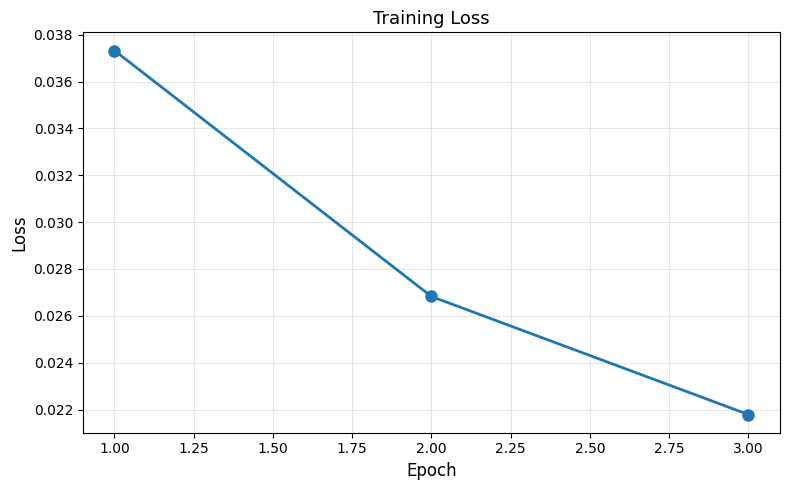

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_epochs+1), history['loss'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 模型評估與視覺化

### 8.1 在 Test Set 上預測

In [30]:
# 為 test set 創建 DataLoader
# 使用與 training set 相同的方法
# 方法 1：提前轉換
test_features = test_ds[feature_vars].to_array(dim='variable')
test_labels = test_ds['convection_flag']

X_test_bgen = xbatcher.BatchGenerator(
    test_features,
    input_dims={'variable': 4, **SPATIAL_PATCH_SIZE},
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

y_test_bgen = xbatcher.BatchGenerator(
    test_labels,
    input_dims=SPATIAL_PATCH_SIZE,
    batch_dims={'time': TIME_BATCH_SIZE},
    preload_batch=False
)

test_dataset = MapDataset(X_test_bgen, y_test_bgen)


test_loader = DataLoader(
    test_dataset,
    batch_size=None,
    shuffle=False,  # Test 不 shuffle
    num_workers=4,  # <-- USE WORKERS
    pin_memory=True, # <-- Add this for speed
    multiprocessing_context='forkserver' # <-- This avoids the conflict
)

print(f"Test set: {len(test_loader)} batches")

Test set: 390 batches


In [31]:
# Evaluation
model.eval()
test_loss = 0.0
predictions = []
targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        test_loss += loss.item()
        predictions.append(outputs.cpu())
        targets.append(y_batch.cpu())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# Concatenate all predictions
predictions = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

print(f"\nPredictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")

Test Loss: 0.0070

Predictions shape: torch.Size([6240, 12, 12])
Targets shape: torch.Size([6240, 12, 12])


### 8.2 計算分類指標

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 轉為 binary predictions (threshold = 0.5)
pred_binary = (predictions > 0.5).float()

# Flatten for sklearn
pred_flat = pred_binary.flatten().numpy()
target_flat = targets.flatten().numpy()

# Calculate metrics
accuracy = accuracy_score(target_flat, pred_flat)
precision = precision_score(target_flat, pred_flat, zero_division=0)
recall = recall_score(target_flat, pred_flat, zero_division=0)
f1 = f1_score(target_flat, pred_flat, zero_division=0)

print("Classification Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")

Classification Metrics:
  Accuracy:  0.9976
  Precision: 0.9919
  Recall:    0.9837
  F1 Score:  0.9878


### 8.3 視覺化：預測 vs 真實

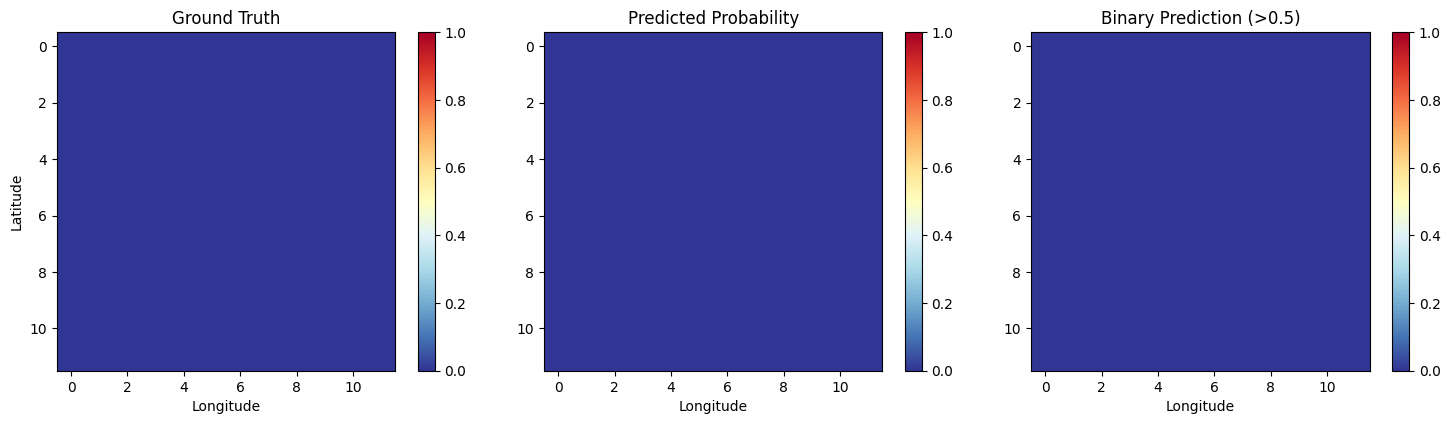

In [33]:
# 選取一個時間步驟和空間 patch 來視覺化
t_idx = 10  # 第 10 個時間步

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# True labels
im1 = axes[0].imshow(targets[t_idx], cmap='RdYlBu_r', vmin=0, vmax=1)
axes[0].set_title('Ground Truth', fontsize=12)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0])

# Predictions (probability)
im2 = axes[1].imshow(predictions[t_idx], cmap='RdYlBu_r', vmin=0, vmax=1)
axes[1].set_title('Predicted Probability', fontsize=12)
axes[1].set_xlabel('Longitude')
plt.colorbar(im2, ax=axes[1])

# Binary predictions
im3 = axes[2].imshow(pred_binary[t_idx], cmap='RdYlBu_r', vmin=0, vmax=1)
axes[2].set_title('Binary Prediction (>0.5)', fontsize=12)
axes[2].set_xlabel('Longitude')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

## 9. 使用 xskillscore 進行空間驗證

### 為什麼需要 xskillscore？

傳統 ML 評估（accuracy, F1）把所有像素當作獨立樣本，忽略了：
- **空間連續性**：相鄰格點的預測應該平滑
- **空間尺度**：大範圍的錯誤 vs 小範圍的錯誤
- **空間相關**：預測的空間結構是否合理？

xskillscore 提供「空間感知」的驗證指標：
- **Spatial correlation**：預測場與真實場的空間相關
- **RMSE by region**：不同區域的誤差
- **Fractions Skill Score**：考慮空間鄰域的驗證

### 為什麼 xskillscore 適合這個 workflow？

xskillscore 直接接受 **Xarray DataArray**：
- 保留經緯度座標
- 可以做區域加權（area-weighted metrics）
- 可以沿著不同維度計算（時間、空間、ensemble）

這就是為什麼我們用 Xarray 而不是 pandas/NumPy 的原因之一。

### 9.1 將預測轉回 Xarray

我們需要把 PyTorch Tensor 轉回 Xarray，恢復座標資訊。

In [34]:
# 注意：這裡是簡化版，實務上需要正確對應每個 patch 的座標
# 為了示範，我們假設 predictions 和 test_ds 的空間範圍相同

# 取得一個 batch 的座標
sample_batch = next(iter(X_test_bgen))
time_coords = sample_batch['time'].values
lat_coords = sample_batch['latitude'].values
lon_coords = sample_batch['longitude'].values

# 創建 Xarray DataArray
pred_da = xr.DataArray(
    predictions[:len(time_coords)].numpy(),  # 限制到實際的時間長度
    dims=['time', 'latitude', 'longitude'],
    coords={
        'time': time_coords,
        'latitude': lat_coords,
        'longitude': lon_coords
    },
    name='convection_probability'
)

target_da = xr.DataArray(
    targets[:len(time_coords)].numpy(),
    dims=['time', 'latitude', 'longitude'],
    coords={
        'time': time_coords,
        'latitude': lat_coords,
        'longitude': lon_coords
    },
    name='convection_truth'
)

print("Predictions as Xarray:")
print(pred_da)
print()
print("Targets as Xarray:")
print(target_da)

Predictions as Xarray:
<xarray.DataArray 'convection_probability' (time: 16, latitude: 12,
                                            longitude: 12)> Size: 9kB
array([[[-17.173403 , -19.019053 , -18.460825 , ..., -19.159716 ,
         -19.308367 , -14.475756 ],
        [-22.301394 , -25.211578 , -23.585396 , ..., -24.007906 ,
         -24.265402 , -19.92147  ],
        [-20.790676 , -23.11132  , -21.883278 , ..., -22.351637 ,
         -22.610168 , -18.895521 ],
        ...,
        [-18.025856 , -20.247501 , -18.905922 , ..., -20.078903 ,
         -21.70073  , -18.800888 ],
        [-15.4092865, -18.358889 , -18.47199  , ..., -18.581459 ,
         -20.490017 , -18.562979 ],
        [ -9.073914 , -12.643888 , -14.081614 , ..., -15.692265 ,
         -16.683403 , -15.598829 ]],

       [[-19.496725 , -20.433416 , -20.313444 , ..., -20.919067 ,
         -21.45779  , -18.087759 ],
        [-23.851599 , -25.154522 , -24.214499 , ..., -25.982231 ,
         -25.54564  , -22.533644 ],
        

### 9.2 計算空間相關係數

In [38]:
pred_da

<xarray.DataArray 'convection_probability' (time: 16, latitude: 12,
                                            longitude: 12)> Size: 9kB
array([[[-17.173403 , -19.019053 , -18.460825 , ..., -19.159716 ,
         -19.308367 , -14.475756 ],
        [-22.301394 , -25.211578 , -23.585396 , ..., -24.007906 ,
         -24.265402 , -19.92147  ],
        [-20.790676 , -23.11132  , -21.883278 , ..., -22.351637 ,
         -22.610168 , -18.895521 ],
        ...,
        [-18.025856 , -20.247501 , -18.905922 , ..., -20.078903 ,
         -21.70073  , -18.800888 ],
        [-15.4092865, -18.358889 , -18.47199  , ..., -18.581459 ,
         -20.490017 , -18.562979 ],
        [ -9.073914 , -12.643888 , -14.081614 , ..., -15.692265 ,
         -16.683403 , -15.598829 ]],

       [[-19.496725 , -20.433416 , -20.313444 , ..., -20.919067 ,
         -21.45779  , -18.087759 ],
        [-23.851599 , -25.154522 , -24.214499 , ..., -25.982231 ,
         -25.54564  , -22.533644 ],
        [-22.896893 , -24.815151 , -22.9862   , ..., -24.742805 ,
         -24.536852 , -22.047909 ],
...
        [-15.464943 , -17.09847  , -16.093525 , ..., -17.633278 ,
         -18.871973 , -17.216785 ],
        [-15.64122  , -16.86869  , -15.262842 , ..., -16.398355 ,
         -17.592896 , -16.748655 ],
        [-14.118039 , -14.240811 , -12.975649 , ..., -13.918455 ,
         -15.174892 , -15.362896 ]],

       [[-13.7412195, -14.358759 , -13.551042 , ..., -12.711799 ,
         -12.684585 , -11.68794  ],
        [-15.35449  , -16.260525 , -14.896474 , ..., -14.818609 ,
         -15.293791 , -15.3958845],
        [-13.942536 , -14.702192 , -13.425315 , ..., -13.7593565,
         -14.318906 , -15.299845 ],
        ...,
        [-11.66789  , -12.819646 , -12.248221 , ..., -12.391726 ,
         -13.177385 , -13.886484 ],
        [-11.824825 , -12.866752 , -12.009445 , ..., -12.820055 ,
         -13.276084 , -13.902933 ],
        [-12.501532 , -12.611912 , -12.152364 , ..., -12.608537 ,
         -13.163425 , -13.1812525]]], shape=(16, 12, 12), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 128B 2019-11-06 2019-11-07 ... 2019-11-21
  * latitude   (latitude) float32 48B 40.0 39.75 39.5 39.25 ... 37.75 37.5 37.25
  * longitude  (longitude) float32 48B 100.0 100.2 100.5 ... 102.2 102.5 102.8

Spatial correlation (per time step):
[20.09913  20.403372 19.802994 18.308899 16.388433 17.933294 19.038435
 12.828069 14.149557 16.83564  17.64566  15.560429 14.674142 18.308268
 18.191088 13.338891]

Mean spatial correlation: 17.0941
Std: 2.3185


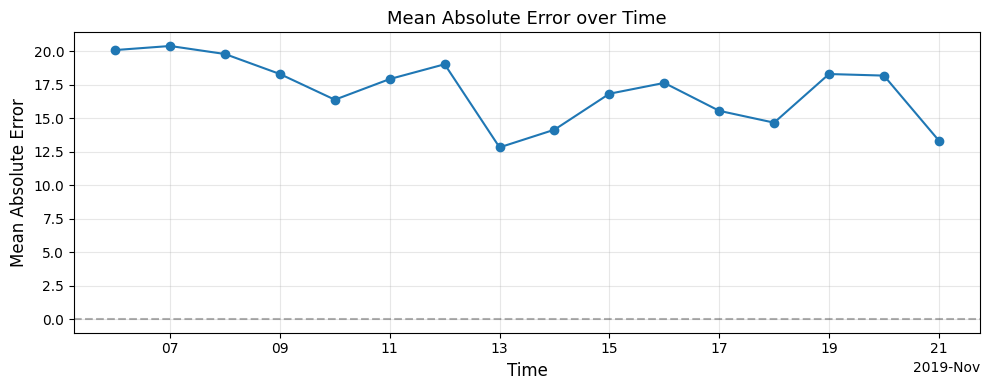

In [40]:
import xskillscore as xs

# 計算每個時間步的空間相關
spatial_corr = xs.mae(pred_da, target_da, dim=['latitude', 'longitude'])

print("Spatial correlation (per time step):")
print(spatial_corr.values)
print()
print(f"Mean spatial correlation: {spatial_corr.mean().values:.4f}")
print(f"Std: {spatial_corr.std().values:.4f}")

# 繪圖
plt.figure(figsize=(10, 4))
spatial_corr.plot(marker='o')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.title('Mean Absolute Error over Time', fontsize=13)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.3 計算空間 RMSE

Overall RMSE: 17.3584


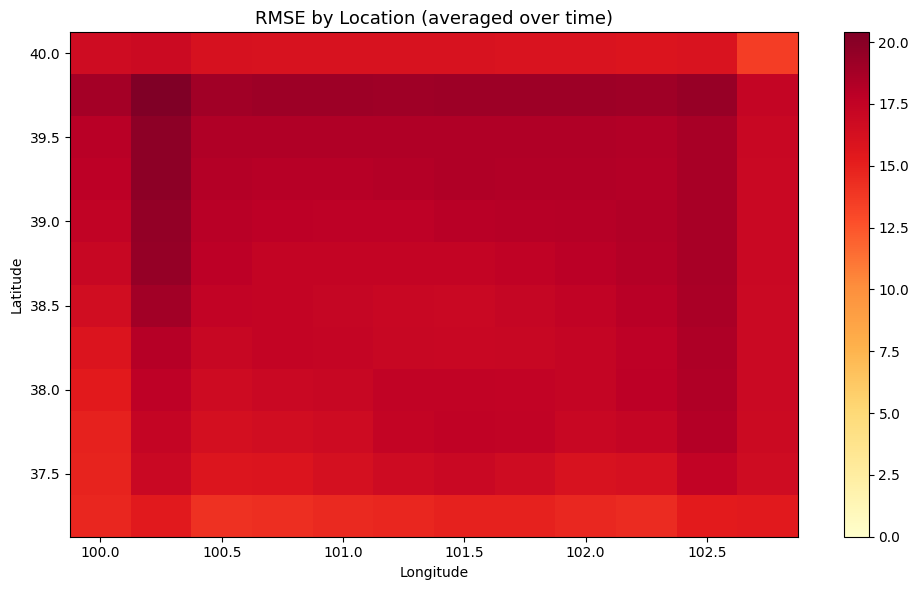


Interpretation:
紅色區域：模型預測誤差較大
黃色/綠色：預測較準確
可以幫助識別模型在哪些地理位置表現較差


In [37]:
# 計算 RMSE
rmse = xs.rmse(pred_da, target_da, dim=['time', 'latitude', 'longitude'])

print(f"Overall RMSE: {rmse.values:.4f}")

# 也可以計算每個格點的時間 RMSE
rmse_spatial = xs.rmse(pred_da, target_da, dim='time')

plt.figure(figsize=(10, 6))
rmse_spatial.plot(cmap='YlOrRd', vmin=0)
plt.title('RMSE by Location (averaged over time)', fontsize=13)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("紅色區域：模型預測誤差較大")
print("黃色/綠色：預測較準確")
print("可以幫助識別模型在哪些地理位置表現較差")

## 10. 完整 Workflow 回顧

讓我們回顧整個從「大型 N-D array」到「ML 模型」的流程：

```
1. 資料儲存
   Zarr (on-disk, chunked)
   ↓
   
2. 資料讀取
   intake-xarray + Dask
   ↓ (lazy)
   
3. 前處理
   - Resample (hourly → daily)
   - 建立 labels
   - 時間序列分割
   ↓ (still lazy)
   
4. Batch 生成
   xbatcher.BatchGenerator
   ↓
   
5. PyTorch 整合
   xbatcher.loaders.torch.MapDataset
   ↓
   
6. 資料載入
   DataLoader (batch_size=None)
   ↓ (now eager, on-demand)
   
7. 模型訓練
   PyTorch training loop
   ↓
   
8. 預測與評估
   - 傳統 metrics (accuracy, F1)
   - 空間 metrics (xskillscore)
   ↓
   
9. 結果視覺化
   Xarray + matplotlib
```

### 關鍵設計原則

1. **Lazy as long as possible**
   - 直到 DataLoader 迭代時才實際讀取資料
   - 減少記憶體佔用

2. **保留元資料**
   - 使用 Xarray 而不是 NumPy
   - 座標資訊對驗證和視覺化很重要

3. **批次處理**
   - xbatcher 自動處理時空切分
   - 不需要手動管理索引

4. **平行化**
   - Dask 處理資料讀取的平行化
   - DataLoader 的 num_workers 處理前處理平行化
   - GPU 處理模型訓練平行化

## 11. 常見問題與除錯

### Q1: DataLoader 報錯 "batch_size should be None"

**原因**：xbatcher 已經定義了 batch，不應該再用 DataLoader 的 batch_size。

**解法**：
```python
DataLoader(dataset, batch_size=None, ...)  # 正確
DataLoader(dataset, batch_size=4, ...)     # 錯誤！
```

### Q2: Multiprocessing 報錯 "cannot pickle Client"

**原因**：Dask Client 無法被 pickle，但 DataLoader 的 multiprocessing 需要 pickle。

**解法**：
```python
DataLoader(..., multiprocessing_context='forkserver')  # 使用 forkserver
# 或
DataLoader(..., num_workers=0)  # 不使用 multiprocessing
```

### Q3: 記憶體不足（OOM）

**原因**：
- Batch 太大（時間或空間維度）
- preload_batch=True
- num_workers 太多

**解法**：
1. 減小 batch_dims 或 input_dims
2. 確保 preload_batch=False
3. 減少 num_workers
4. 調整 Dask Client 的 memory_limit

### Q4: 訓練很慢

**可能原因**：
- I/O 瓶頸：增加 num_workers
- Chunk 太小：考慮 rechunk
- CPU 計算：檢查是否正確使用 GPU

**除錯**：觀察 Dask Dashboard，看時間花在哪裡。

## 12. 延伸方向

這個 workshop 展示了基礎流程，實務上可以延伸：

### 資料面
- 加入更多變數（濕度、風場、溫度剖面）
- 多資料來源融合（ERA5 + 衛星 + 地面觀測）
- 時間滯後特徵（t-1, t-2 小時的資料）

### 模型面
- 更複雜的架構（UNet, ResNet, Transformer）
- 序列模型（LSTM, GRU）用於時間序列
- Ensemble 模型

### 訓練面
- Class imbalance 處理（weighted loss, focal loss）
- Data augmentation（spatial flip, rotation）
- Transfer learning（預訓練模型）

### 驗證面
- 更多空間指標（Fractions Skill Score, SAL）
- Case study（分析特定事件）
- 區域化評估（山區 vs 平地）

## 13. 總結

完成這個 notebook 後，你應該能夠：

- [ ] 定義適合 ML 的氣象任務
- [ ] 建立有意義的 labels
- [ ] 使用 xbatcher 產生時空 batches
- [ ] 正確整合 xbatcher 與 PyTorch
- [ ] 設定 DataLoader（batch_size=None!）
- [ ] 訓練一個簡單的 CNN 模型
- [ ] 使用 xskillscore 進行空間驗證
- [ ] 理解完整的 out-of-core ML workflow

### 核心要點

1. **xbatcher 的兩階段設計是關鍵**
   - BatchGenerator → MapDataset
   - 不要自己寫 Dataset wrapper

2. **batch_size=None 避免維度錯誤**
   - xbatcher 已經定義 batch
   - DataLoader 只負責 shuffling 和 multiprocessing

3. **保留空間資訊很重要**
   - 轉回 Xarray 做驗證
   - 空間相關性是氣象預報的核心

4. **Lazy evaluation 貫穿整個流程**
   - 從 Zarr 讀取到 DataLoader 都是 lazy
   - 只在需要時才載入資料

這個工作流程可以擴展到：
- 更大的資料集（TB 級別）
- 更複雜的模型（深度學習）
- 分散式訓練（多 GPU、多節點）

重點是**理解原理**，而不是記住 API。

In [ ]:
# 關閉 Dask Client
# client.close()

print("Workshop completed! 🎉")